In [1]:
import os 
import torch 
import fnmatch
from torch import nn
from PIL import Image
from torchvision import transforms 
from tqdm.auto import tqdm 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt 

C:\Users\Sania\gans-data-augmentation\gans_data_aug\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATHS = {
    "dataset": "./dataset/", 
    "checkpoints": "./checkpoints/"
}

In [3]:
class PetrolPumpDataset(Dataset): 
    def __init__(self, img_dir, transform=None, extensions=['*.jpg', '*.jpeg', '*.png']):
        self.extensions = extensions 
        self.img_dir = img_dir
        self.image_paths = [f"{img_dir}/{img}" for img in os.listdir(img_dir) if any(fnmatch.fnmatch(img, ext) for ext in extensions)]
        self.transform = transform 
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, idx): 
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform: 
            image = self.transform(image)
            
        return image

In [4]:
dataset = PetrolPumpDataset(DATA_PATHS["dataset"], transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
]))

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
img = next(iter(dataloader))
img[0].shape

torch.Size([3, 256, 256])

In [6]:
def show_tensor_images(image_tensor, num_images=1):
    image_tensor = image_tensor.detach().cpu()
    image_tensor = image_tensor.permute(1, 2, 0)

    # Handling normalization 
    image_tensor = torch.clamp(image_tensor, min=0, max=1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()


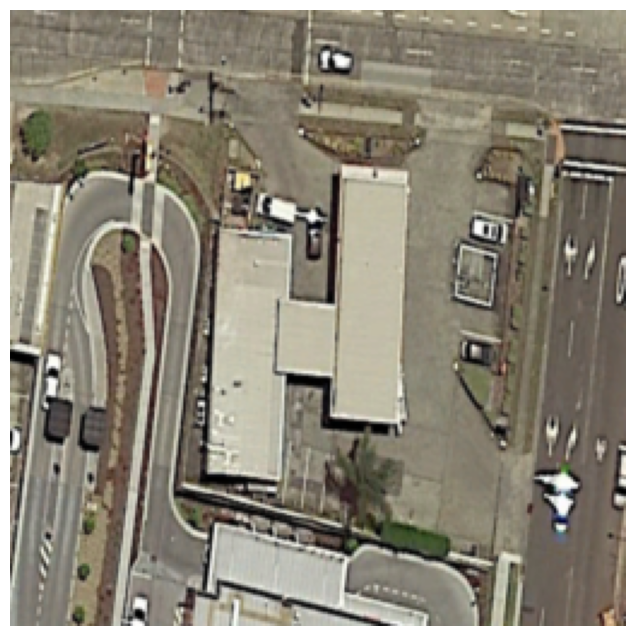

In [7]:
show_tensor_images(img[10])

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, input_channels=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.generator_block(z_dim, hidden_dim * 32, stride=1, padding=0),  
            self.generator_block(hidden_dim * 32, hidden_dim * 16), 
            self.generator_block(hidden_dim * 16, hidden_dim * 8),  
            self.generator_block(hidden_dim * 8, hidden_dim * 4),  
            self.generator_block(hidden_dim * 4, hidden_dim * 2),  
            self.generator_block(hidden_dim * 2, hidden_dim), 
            self.generator_block(hidden_dim, input_channels, final_layer=True) 
        )
        
    def generator_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False): 
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh()
            )
        
    def forward(self, noise):
        return self.gen(noise.view(len(noise), self.z_dim, 1, 1))
    
    def get_gen(self):
        return self.gen

In [9]:
def get_noise(n_samples, z_dim, device='cpu'): 
    return torch.randn(n_samples, z_dim, device=device)

In [16]:
class Critic(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=64):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            self.critic_block(input_channels, hidden_dim),
            self.critic_block(hidden_dim, hidden_dim * 2),
            self.critic_block(hidden_dim * 2, hidden_dim * 4),
            self.critic_block(hidden_dim * 4, hidden_dim * 8),
            self.critic_block(hidden_dim * 8, hidden_dim * 16),
            self.critic_block(hidden_dim * 16, hidden_dim * 32),
            self.critic_block(hidden_dim * 32, 1, stride=1, final_layer=True)
        )
        
    def critic_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
            )

    def forward(self, image):
        critic_pred = self.critic(image)
        return critic_pred.view(-1, 1) 

    def get_critic(self):
        return self.critic

In [62]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64 
display_step = 50  
batch_size = 4  
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
critic_repeats = 3
device='cuda'

In [63]:
import torch

# Clear cached memory
torch.cuda.empty_cache()

# Optional: Reset CUDA state
torch.cuda.reset_max_memory_allocated()

In [64]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
critic = Critic().to(device) 
critic_opt = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [65]:
def display_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [66]:
def save_checkpoints(gen, disc, gen_opt, disc_opt, gen_loss, disc_loss, path): 
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'gen_opt_state_dict': gen_opt.state_dict(),
        'disc_opt_state_dict': disc_opt.state_dict(),
        'gen_loss': gen_loss,
        'disc_loss': disc_loss
    }, path)

#### Gradient Penalty 

In [67]:
def get_gradient(critic, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = critic(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images, 
        outputs=mixed_scores, 
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True, 
        retain_graph=True
    )[0]

    return gradient 


def compute_gradient_penalty(gradient): 
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)

    return penalty 

In [68]:
def get_gen_loss(critc_fake_pred): 
    return (-1. * torch.mean(critc_fake_pred))

def get_critic_loss(critic_fake_pred, critic_real_pred, gradient_penalty, c_lambda):
    return (torch.mean(critic_fake_pred) - torch.mean(critic_real_pred) + c_lambda * gradient_penalty)

 14%|████████████                                                                        | 1/7 [01:39<09:58, 99.71s/it]

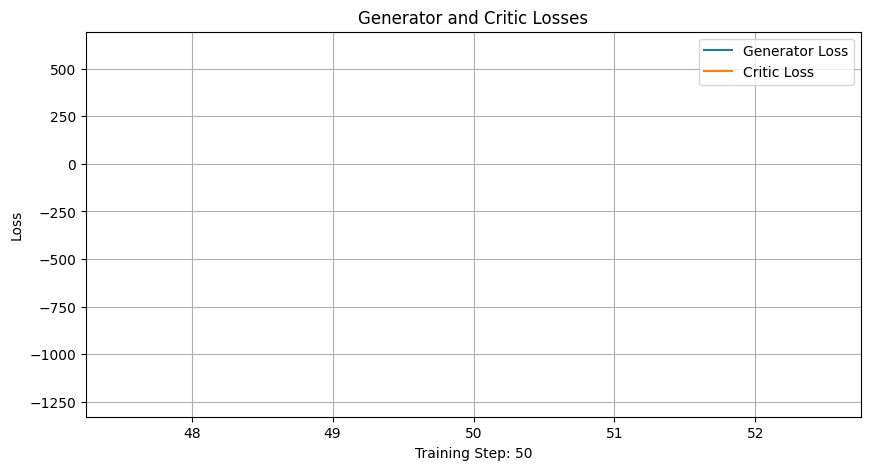

Step 50: Generator loss: 601.3236012268067, critic loss: -1235.3603625996902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


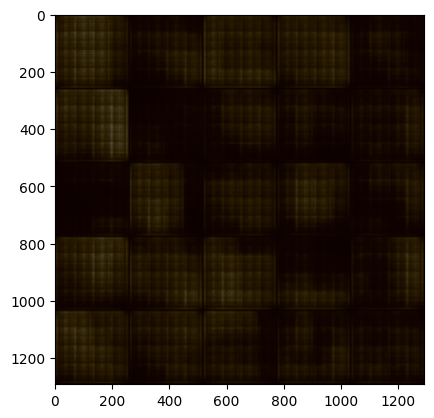

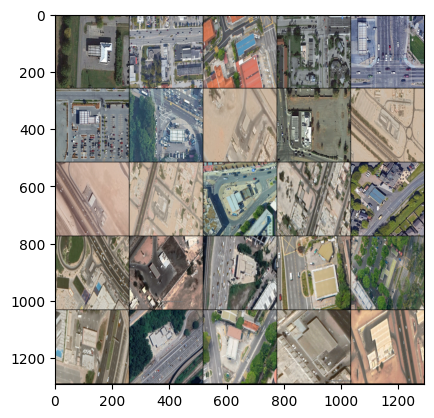

 43%|███████████████████████████████████▌                                               | 3/7 [05:35<07:26, 111.67s/it]


KeyboardInterrupt: 

In [70]:
current_step = 0
total_generator_loss = 0
total_critic_loss = 0

generator_losses = [] 
critic_losses = [] 
steps = [] 

import time
start_time = time.time()

for epoch in range(n_epochs):
    for real in tqdm(dataloader):
        batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0 
        for _ in range(critic_repeats): 
            critic_opt.zero_grad()
            fake_noise = get_noise(batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            critic_fake_pred = critic(fake.detach())
            critic_real_pred = critic(real)
            
            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(critic, real, fake.detach(), epsilon)
            gradient_penalty = compute_gradient_penalty(gradient)
            
            critic_loss = get_critic_loss(critic_fake_pred, critic_real_pred, gradient_penalty, c_lambda)
            
            mean_iteration_critic_loss += critic_loss.item() / critic_repeats
            critic_loss.backward(retain_graph=True)
            critic_opt.step()
        
        total_critic_loss += mean_iteration_critic_loss
        
        gen_opt.zero_grad()
        fake_noise_gen = get_noise(batch_size, z_dim, device=device)
        fake_gen = gen(fake_noise_gen)
        critic_fake_pred = critic(fake_gen)

        gen_loss = get_gen_loss(critic_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        
        total_generator_loss += gen_loss.item() 

        if current_step % display_step == 0 and current_step > 0:
            mean_critic_loss = total_critic_loss / display_step 
            mean_generator_loss = total_generator_loss / display_step 
            
            generator_losses.append(mean_generator_loss)
            critic_losses.append(mean_critic_loss)
            steps.append(current_step)
            
            plt.figure(figsize=(10, 5))
            plt.plot(steps, generator_losses, label='Generator Loss')
            plt.plot(steps, critic_losses, label='Critic Loss')
            plt.xlabel(f'Training Step: {current_step}')
            plt.ylabel('Loss')
            plt.title('Generator and Critic Losses')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            print(f"Step {current_step}: Generator loss: {mean_generator_loss}, critic loss: {mean_critic_loss}")
            fake_noise = get_noise(batch_size, z_dim, device)
            fake = gen(fake_noise)
            display_tensor_images(fake)
            display_tensor_images(real)
            total_discriminator_loss = 0
            total_generator_loss = 0
        current_step += 1
        
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

In [22]:
save_checkpoints(gen, disc, gen_opt, disc_opt, gen_loss, disc_loss, f'{DATA_PATHS["checkpoints"]}/checkpoint_61000.pt')